# Twitter sentiment analysis with Logistic Regression and XGBoost

![pexels-brett-jordan-5417837.jpg](https://images.pexels.com/photos/5417837/pexels-photo-5417837.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)

In this notebook I present a simple regression modeling of the sentiment analysis of a database of tweets related to specific companies. This is structured as follows:

1. Initial data transformation
2. Plotting features
3. Text analysis
4. Logistic Regression model
5. XGBoost model
6. Final Remarks

The main objective is to present a simple NLP project and to practice the main uses of libraries such as `wordcloud`,`sklearn`, `nltk` and `re`.

# 1. Initial data transformation

As an initial approach, all the main libraries and functions were summarized in the following cell, focusing on data visualization, text analysis, text vectorization, and model building.

Additionally, the stopwords from English were downloaded from the `nltk` library.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
pd.options.mode.chained_assignment = None
import os #File location
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
import re #Regular expressions
import nltk
from nltk import word_tokenize
nltk.download('stopwords')

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Then, the validation and train datasets were saved on two variables by using the function of `read_csv` from pandas, where both didn't have a data header.

In [2]:
#Validation dataset
val=pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None)
#Full dataset for Train-Test
train=pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None)

Later, the columns were renamed to represent the given data of tweets. But, with the first 5 rows analysis, it was recognized that positive sentiment was assigned to a "kill" thread related to a videogame. Even with this in consideration, the modeling, in this case, will the same as a traditional NLP project.

In [3]:
train.columns=['id','information','type','text']
train.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Then, with the validation data, the information of the first 5 rows didn't show any unusual labeling.

In [4]:
val.columns=['id','information','type','text']
val.head()

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [5]:
train_data=train
train_data

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [6]:
val_data=val
val_data

,id,information,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


To prepare the data for the text analysis an additional row was created using the method of `str.lower`. However, as there were some texts with only numerical values (such as one that only had a 2 as the tweet) an additional function was used for transforming all the data to string.

Then, a regex expression erased the special characters as it is common to have digitation problems on Twitter.

In [7]:
#Text transformation
train_data["lower"]=train_data.text.str.lower() #lowercase
train_data["lower"]=[str(data) for data in train_data.lower] #converting all to string
train_data["lower"]=train_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex
val_data["lower"]=val_data.text.str.lower() #lowercase
val_data["lower"]=[str(data) for data in val_data.lower] #converting all to string
val_data["lower"]=val_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

The differences between the two text columns are presented in the next table.

In [8]:
train_data.head()

,id,information,type,text,lower
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


# 2. Plotting features

As to identify the main words that were used per label, a word_cloud was used to see which are the most important words on the train data. For example, on the positive label words such as love and game were mostly used alongside a wide variety of words classified as "good sentiments".

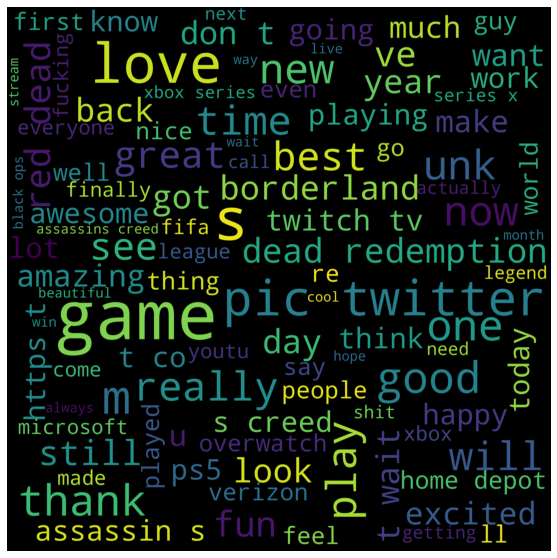

In [9]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Positive"].lower)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As for the negative tweets, some curse words were the most important while the names of some games and industries were also very used, such as facebook and eamaddennfl. 

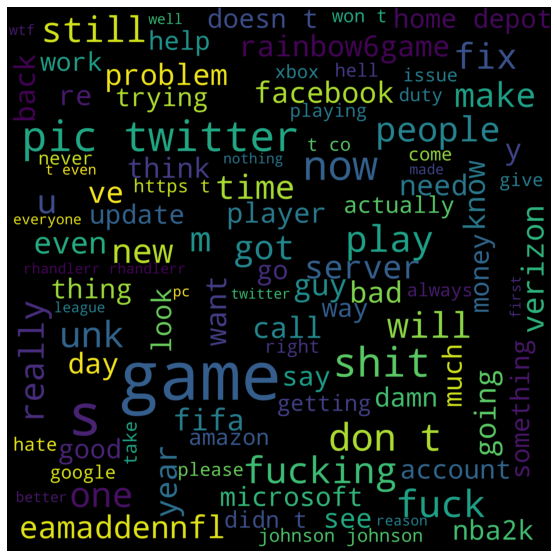

In [10]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Negative"].lower)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The irrelevant tweets show a similar trend as negative ones, something that will impact the overall prediction performance.

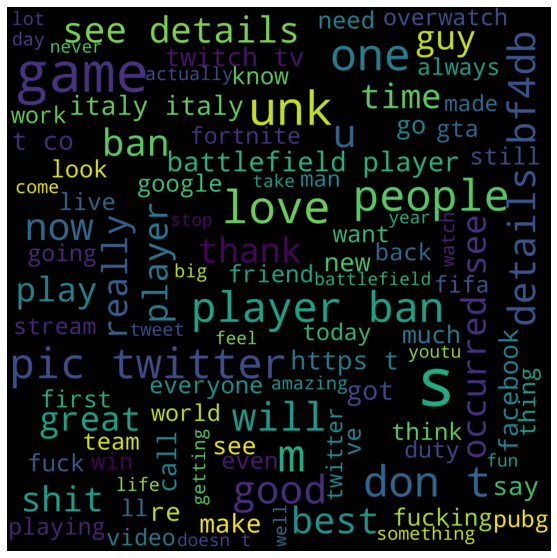

In [11]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Irrelevant"].lower)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Then, on the neutral side, there are almost no curse words and the most important ones are different from the other 3 categories.

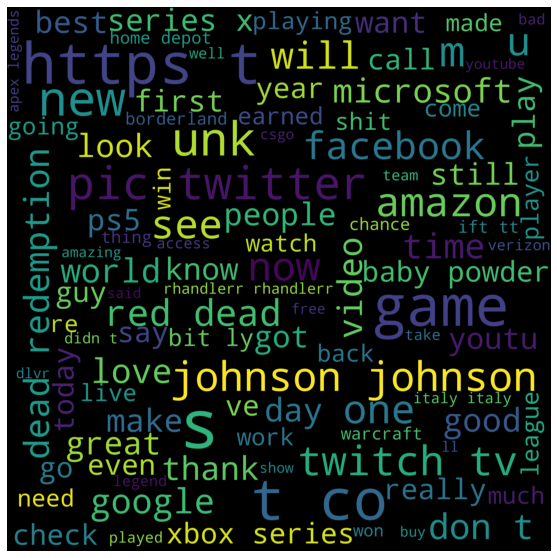

In [12]:
word_cloud_text = ''.join(train_data[train_data["type"]=="Neutral"].lower)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Finally, in this section, the information was grouped by the brand (or in this case the column information) to make a barplot that shows the number of tweets for each one.

In [13]:
#Count information per category
plot1=train.groupby(by=["information","type"]).count().reset_index()
plot1.head()

,information,type,id,text,lower
0,Amazon,Irrelevant,192,186,192
1,Amazon,Negative,576,575,576
2,Amazon,Neutral,1236,1207,1236
3,Amazon,Positive,312,308,312
4,ApexLegends,Irrelevant,192,192,192


As an interesting fact, the number of modified texts coincides with the id. For this reason, as the ID is unique, the following barplot shows that for games such as MaddenNFL and NBA2K the number of negative tweets is the highest while on the other brands the trend is different.

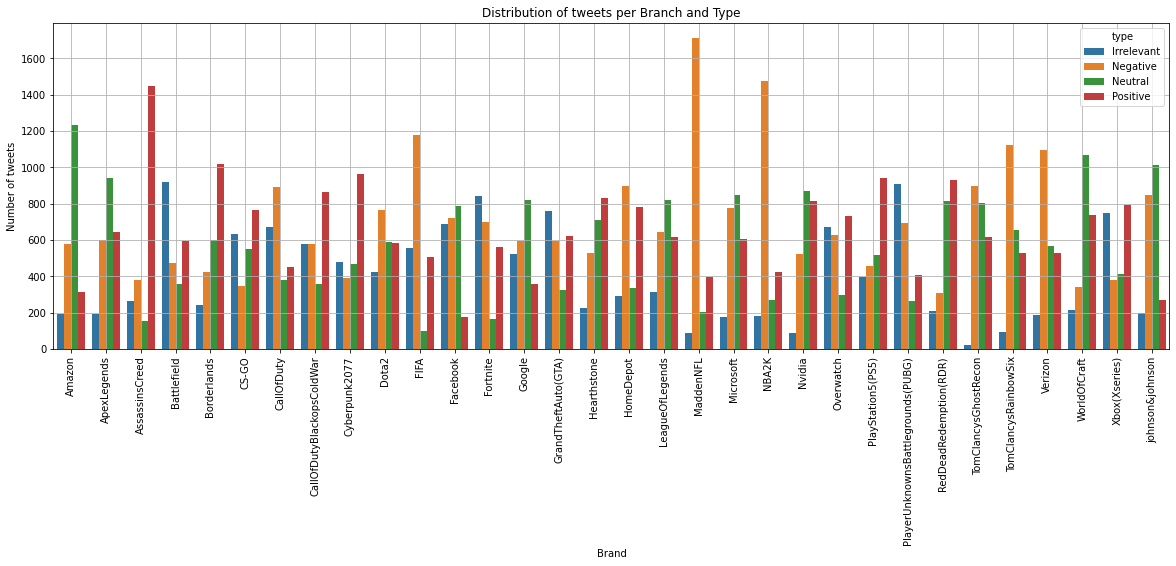

In [14]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=plot1,x="information",y="id",hue="type")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type");

# 3. Text analysis

With the clean text, the initial number of unique tokens was counted to identify the model complexity. As presented, there are more than 30 thousand unique words.

In [15]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in train_data.lower]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  30436


The tokens_text variable groups all the texts by the different words stored on a List.

In [16]:
tokens_text[1]

['i',
 'am',
 'coming',
 'to',
 'the',
 'borders',
 'and',
 'i',
 'will',
 'kill',
 'you',
 'all']

Also, the main English stopwords were saved on an additional variable, to be used in the following modeling.

In [17]:
#Choosing english stopwords
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

# 4. Logistic Regression model

For the main regression model, it was used a simple Logistic Regression of the sklearn library alongside the Bag of Words (BoW) approach. This last method helps to classify and group the relevant data to help the model identify the proper trends.

On this first BoW, the stopwords were considered alongside a default [ngram](https://deepai.org/machine-learning-glossary-and-terms/n-gram) of 1.

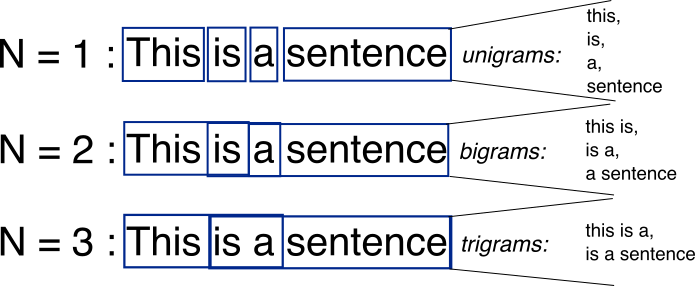

In [18]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

Then, the main data was split on train and test datasets alongside the encoding of the words by using the training dataset as a reference:

In [19]:
#Train - Test splitting
reviews_train, reviews_test = train_test_split(train_data, test_size=0.2, random_state=0)

In [20]:
#Creation of encoding related to train dataset
X_train_bow = bow_counts.fit_transform(reviews_train.lower)
#Transformation of test dataset with train encoding
X_test_bow = bow_counts.transform(reviews_test.lower)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


In [21]:
X_test_bow

<14937x28993 sparse matrix of type '<class 'numpy.int64'>'
	with 161222 stored elements in Compressed Sparse Row format>

In [22]:
#Labels for train and test encoding
y_train_bow = reviews_train['type']
y_test_bow = reviews_test['type']

The total number of tweets for each category shows that negative and positive are the most registered while the irrelevant is the lowest.

In [23]:
#Total of registers per category
y_test_bow.value_counts() / y_test_bow.shape[0]

Negative      0.299190
Positive      0.282252
Neutral       0.245632
Irrelevant    0.172926
Name: type, dtype: float64

With this data, the Logistic Regression Model was trained, where accuracy of 81% on the test dataset was obtained while on the validation dataset this value increased to 91%.

In [24]:
# Logistic regression
model1 = LogisticRegression(C=1, solver="liblinear",max_iter=200)
model1.fit(X_train_bow, y_train_bow)
# Prediction
test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred) * 100)

Accuracy:  81.50900448550578


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [25]:
#Validation data
X_val_bow = bow_counts.transform(val_data.lower)
y_val_bow = val_data['type']

In [26]:
X_val_bow

<1000x28993 sparse matrix of type '<class 'numpy.int64'>'
	with 12913 stored elements in Compressed Sparse Row format>

In [27]:
Val_res = model1.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_res) * 100)

Accuracy:  91.7


Finally, another Bag of Words was used. This had an n-gram of 4 while not classifying the stopwords, using all the available information.

The Test dataset got to 90% while on the validation data the accuracy was 98%, showing that this approach was better than the simple n-gram and stopwords model.

In [28]:
#n-gram of 4 words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)
#Data labeling
X_train_bow = bow_counts.fit_transform(reviews_train.lower)
X_test_bow = bow_counts.transform(reviews_test.lower)
X_val_bow = bow_counts.transform(val_data.lower)

In [29]:
X_train_bow

<59745x1427378 sparse matrix of type '<class 'numpy.int64'>'
	with 4142213 stored elements in Compressed Sparse Row format>

In [30]:
model2 = LogisticRegression(C=0.9, solver="liblinear",max_iter=1500)
# Logistic regression
model2.fit(X_train_bow, y_train_bow)
# Prediction
test_pred_2 = model2.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_2) * 100)

Accuracy:  90.79467095132891


In [31]:
y_val_bow = val_data['type']
Val_pred_2 = model2.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_pred_2) * 100)

Accuracy:  98.6


# XGBoost approach

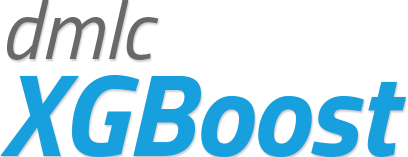

As the data is already transformed, the additional step was to use another prediction modeling, such as the well know [XGBoost](https://xgboost.readthedocs.io/en/stable/). For this case, the last bag of words was used alongside the XGBoost Classifier:

In [32]:
# https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got
le = LabelEncoder()
y_train_bow_num = le.fit_transform(y_train_bow)
y_test_bow_num=le.transform(y_test_bow)
y_val_bow_num=le.transform(y_val_bow)

In [33]:
%%time
XGB=XGBClassifier(objective="multi:softmax",n_estimators=1000,colsample_bytree=0.6, subsample=0.6)
XGB.fit(X_train_bow, y_train_bow_num)
# Prediction
test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_num, test_pred_2) * 100)

Accuracy:  84.6823324630113
CPU times: user 1h 3min 3s, sys: 1.82 s, total: 1h 3min 5s
Wall time: 20min 14s


In [34]:
y_val_bow = val_data['type']
Val_pred_2 = XGB.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow_num, Val_pred_2) * 100)

Accuracy:  95.7


At a first glance, with the default XGBoost parameters, the model gets a worse accuracy. For this reason, an additional cell was added to see the training performance:

In [35]:
test_pred_N = XGB.predict(X_train_bow)
print("Accuracy: ", accuracy_score(y_train_bow_num, test_pred_N) * 100)

Accuracy:  93.51912293915808


It was found that the accuracy is the lowest of all the modeling, so parameter tuning is required to improve the overall performance.

# Final remarks and future projects

![pexels-lukas-590022(2).jpg](https://images.pexels.com/photos/590022/pexels-photo-590022.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)

As presented in the notebook, a simple NLP approach helped to obtain a 90% accuracy on the test dataset, even with the labeling problems presented in the initial sections.

The next steps will be the improvement of accuracy with the use of winning competence models alongside an additional EDA analysis for checking labeling and context differences between each of the brands.